### Import libraries


In [1]:
# for data pre-processing 
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords 
#from sklearn.manifold import TSNE
#from gensim.models import KeyedVectors
import gensim.models
from gensim.utils import lemmatize
import nltk 
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tag import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# for classification modelling 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import string
import sklearn.metrics as metrics
from datetime import datetime
from datetime import timedelta

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
import torch

### Import dataset (news headlines and financial data)

In [3]:
pwd

'/Users/admin/Documents/invest'

In [4]:
# import news headlines
df = pd.read_csv('/Users/admin/Documents/invest/investfinaldata.csv')
df = df.drop(['Unnamed: 2','Unnamed: 3'], axis=1)

In [5]:
# import financial data
# include column based on today's close to tomorrow's open (binary classification)
stock_prices = pd.read_csv('AAPLfinal.csv')
stock_prices = stock_prices.drop(['Unnamed: 0'], axis=1)
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])

for i in range(stock_prices.shape[0]-1):
    if stock_prices['Close'][i]<stock_prices['Open'][i+1]:
        stock_prices.loc[i,'response_variable']= 1
    else:
        stock_prices.loc[i,'response_variable']= -1


stock_prices=stock_prices[:stock_prices.shape[0]-1] # remove the last row, no target class

In [6]:
stock_prices[stock_prices['response_variable']==1]

,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,Net.changes.in.cash,response_variable
1,2016-12-02,109.169998,110.089996,108.849998,109.900002,104.734901,26528000,46852,4127,-3902,2247,1.0
2,2016-12-05,110.000000,110.029999,108.250000,109.110001,103.982048,34324500,46852,4127,-3902,2247,1.0
5,2016-12-08,110.860001,112.430000,110.599998,112.120003,106.850578,27068300,46852,4127,-3902,2247,1.0
7,2016-12-12,113.290001,115.000000,112.489998,113.300003,107.975121,26374400,46852,4127,-3902,2247,1.0
9,2016-12-14,115.040001,116.199997,114.980003,115.190002,109.776306,34031800,46852,4127,-3902,2247,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
767,2019-12-19,279.500000,281.179993,278.950012,280.019989,279.356995,24592300,64040,2160,-3479,-1927,1.0
768,2019-12-20,282.230011,282.649994,278.559998,279.440002,278.778381,68994500,64040,2160,-3479,-1927,1.0
769,2019-12-23,280.529999,284.250000,280.369995,284.000000,283.327576,24643000,64040,2160,-3479,-1927,1.0
770,2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,64040,2160,-3479,-1927,1.0


In [7]:
stock_prices[stock_prices['response_variable']==-1]

,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,Net.changes.in.cash,response_variable
0,2016-12-01,110.370003,110.940002,109.029999,109.489998,104.344177,37086900,46852,4127,-3902,2247,-1.0
3,2016-12-06,109.500000,110.360001,109.190002,109.949997,104.782547,26195500,46852,4127,-3902,2247,-1.0
4,2016-12-07,109.260002,111.190002,109.160004,111.029999,105.811821,29998700,46852,4127,-3902,2247,-1.0
6,2016-12-09,112.309998,114.699997,112.309998,113.949997,108.594566,34402600,46852,4127,-3902,2247,-1.0
8,2016-12-13,113.839996,115.919998,113.750000,115.190002,109.776306,43733800,46852,4127,-3902,2247,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
762,2019-12-12,267.779999,272.559998,267.320007,271.459991,270.817261,34327600,64040,2160,-3479,-1927,-1.0
764,2019-12-16,277.000000,280.790009,276.980011,279.859985,279.197357,32046500,64040,2160,-3479,-1927,-1.0
765,2019-12-17,279.570007,281.769989,278.799988,280.410004,279.746094,28539600,64040,2160,-3479,-1927,-1.0
766,2019-12-18,279.799988,281.899994,279.119995,279.739990,279.077667,29007100,64040,2160,-3479,-1927,-1.0


In [8]:
stock_prices.shape

(773, 12)

In [9]:
# classification with three different classes 
'''
stock_prices = pd.read_csv('AAPLfinal.csv')
stock_prices = stock_prices.drop(['Unnamed: 0'], axis=1)
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"])
for i in range(stock_prices.shape[0]-1):
    if stock_prices['Close'][i]<stock_prices['Open'][i+1]:
        stock_prices.loc[i,'response_variable']= 1
    elif stock_prices['Close'][i]>stock_prices['Open'][i+1]:
        stock_prices.loc[i,'response_variable']= -1
    else:
        stock_prices.loc[i,'response_variable']= 0
stock_prices=stock_prices[:stock_prices.shape[0]-1] # remove the last row, no target class
'''

'\nstock_prices = pd.read_csv(\'AAPLfinal.csv\')\nstock_prices = stock_prices.drop([\'Unnamed: 0\'], axis=1)\nstock_prices["Date"] = pd.to_datetime(stock_prices["Date"])\nfor i in range(stock_prices.shape[0]-1):\n    if stock_prices[\'Close\'][i]<stock_prices[\'Open\'][i+1]:\n        stock_prices.loc[i,\'response_variable\']= 1\n    elif stock_prices[\'Close\'][i]>stock_prices[\'Open\'][i+1]:\n        stock_prices.loc[i,\'response_variable\']= -1\n    else:\n        stock_prices.loc[i,\'response_variable\']= 0\nstock_prices=stock_prices[:stock_prices.shape[0]-1] # remove the last row, no target class\n'

# Feature engineering 

1. VADER 
2. Bag of Words 
3. Word Embedding (Word2Vec)

### VADER

In [10]:
df_jj = df.copy()
df_jj = df_jj.groupby(['Date'])['Header'].apply(lambda x: ','.join(x.astype(str))).reset_index() # combine rows with the same data
df_jj["Date"] = pd.to_datetime(df_jj["Date"])
df_jj = df_jj.sort_values("Date")
df_jj = df_jj.reset_index().drop(["index"], axis=1)

In [11]:
ps=PorterStemmer()
lemmatizer=WordNetLemmatizer()
SA=SentimentIntensityAnalyzer()
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
stop_words=set(stopwords.words("english"))

###for headers
for i in range(df_jj.shape[0]):
  tokens=[]
  filtered_tokens=[]
  final = " "
  if(type(df_jj.loc[i,'Header'])==float):
    df_jj.loc[i,'filtered_header'] =final
  else:
    tokens.append((word_tokenize(df_jj.loc[i,'Header'])))
    #filter &stem tokens
    for w in tokens[0]:
      if w not in stop_words:
        result=pos_tag([w])
        if result[0][1].startswith('J'):
            tag=wordnet.ADJ
        elif result[0][1].startswith('V'):
            tag=wordnet.VERB
        elif result[0][1].startswith('N'):
            tag=wordnet.NOUN
        elif result[0][1].startswith('R'):
            tag=wordnet.ADV
        else:
            tag=wordnet.NOUN
        filtered_tokens.append(lemmatizer.lemmatize(word=result[0][0],pos=tag))                      
    for j in filtered_tokens:
      final+=j
      final+= " "
    df_jj.loc[i,'filtered_header'] =final

#stop_words.add() # remove those lines at the top using this / clean the data before running

"""
###for text
for i in range(#):
  tokens=[]
  filtered_tokens=[]
  final = " "
  if(type(news.loc[i,'Text'])==float):
    news.loc[i,'filtered_text'] =final
  else:
    tokens.append((word_tokenize(news.loc[i,'Text'])))
    #filter &stem tokens
    for w in tokens[0]:
      if w not in stop_words:
        result=pos_tag([w])
        if result[0][1].startswith('J'):
            tag=wordnet.ADJ
        elif result[0][1].startswith('V'):
            tag=wordnet.VERB
        elif result[0][1].startswith('N'):
            tag=wordnet.NOUN
        elif result[0][1].startswith('R'):
            tag=wordnet.ADV
        else:
            tag=wordnet.NOUN
        filtered_tokens.append(lemmatizer.lemmatize(word=result[0][0],pos=tag))                      
    for j in filtered_tokens:
      final+=j
      final+= " "
    print(final)
    news.loc[i,'filtered_text'] =final
"""

'\n###for text\nfor i in range(#):\n  tokens=[]\n  filtered_tokens=[]\n  final = " "\n  if(type(news.loc[i,\'Text\'])==float):\n    news.loc[i,\'filtered_text\'] =final\n  else:\n    tokens.append((word_tokenize(news.loc[i,\'Text\'])))\n    #filter &stem tokens\n    for w in tokens[0]:\n      if w not in stop_words:\n        result=pos_tag([w])\n        if result[0][1].startswith(\'J\'):\n            tag=wordnet.ADJ\n        elif result[0][1].startswith(\'V\'):\n            tag=wordnet.VERB\n        elif result[0][1].startswith(\'N\'):\n            tag=wordnet.NOUN\n        elif result[0][1].startswith(\'R\'):\n            tag=wordnet.ADV\n        else:\n            tag=wordnet.NOUN\n        filtered_tokens.append(lemmatizer.lemmatize(word=result[0][0],pos=tag))                      \n    for j in filtered_tokens:\n      final+=j\n      final+= " "\n    print(final)\n    news.loc[i,\'filtered_text\'] =final\n'

In [13]:
###for headers
for i in range(df_jj.shape[0]):
    if df_jj['filtered_header'][i] == " ":
        pol_score=0
    else:
        pol_score= SA.polarity_scores(df_jj['filtered_header'][i])

    df_jj.loc[i,'filtered_header_score']= pol_score.get('compound') # raw score
    df_jj.loc[i,'filtered_header_sentiments']=0

    if pol_score.get('compound')>0.1:
        df_jj.loc[i,'filtered_header_sentiments']=1
    elif pol_score.get('compound')<-0.1:
        df_jj.loc[i,'filtered_header_sentiments']=-1
        
df_jj_final = df_jj.drop(["Header","filtered_header"],axis=1) #  remove unneccessary columns, only need the date and filtered sentiment score


In [14]:
df_jj_final.head()

,Date,filtered_header_score,filtered_header_sentiments
0,2016-01-12,0.4404,1.0
1,2016-02-12,-0.2732,-1.0
2,2016-03-12,-0.3818,-1.0
3,2016-05-12,0.4215,1.0
4,2016-07-12,0.8360,1.0


In [15]:
stock_prices = stock_prices.merge(df_jj_final,on="Date")
stock_prices.head()

,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,Net.changes.in.cash,response_variable,filtered_header_score,filtered_header_sentiments
0,2016-12-12,113.290001,115.000000,112.489998,113.300003,107.975121,26374400,46852,4127,-3902,2247,1.0,0.0000,0.0
1,2016-12-13,113.839996,115.919998,113.750000,115.190002,109.776306,43733800,46852,4127,-3902,2247,-1.0,0.0000,0.0
2,2016-12-14,115.040001,116.199997,114.980003,115.190002,109.776306,34031800,46852,4127,-3902,2247,1.0,-0.3818,-1.0
3,2016-12-16,116.470001,116.500000,115.650002,115.970001,110.519630,44351100,46852,4127,-3902,2247,-1.0,-0.2960,-1.0
4,2016-12-19,115.800003,117.379997,115.750000,116.639999,111.158150,27779400,46852,4127,-3902,2247,1.0,0.0000,0.0


In [16]:
sentiments_df_full=stock_prices.iloc[:,[0,1,3,6,-1,-2,-3]]

In [17]:
sentiments_df_full.head()

,Date,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable
0,2016-12-12,113.290001,112.489998,26374400,0.0,0.0000,1.0
1,2016-12-13,113.839996,113.750000,43733800,0.0,0.0000,-1.0
2,2016-12-14,115.040001,114.980003,34031800,-1.0,-0.3818,1.0
3,2016-12-16,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0
4,2016-12-19,115.800003,115.750000,27779400,0.0,0.0000,1.0


In [18]:
sentiments_df= sentiments_df_full.iloc[:,[1,2,3,4,5,6]]

In [19]:
sentiments_df.head()

,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable
0,113.290001,112.489998,26374400,0.0,0.0000,1.0
1,113.839996,113.750000,43733800,0.0,0.0000,-1.0
2,115.040001,114.980003,34031800,-1.0,-0.3818,1.0
3,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0
4,115.800003,115.750000,27779400,0.0,0.0000,1.0


### Bag of Words 

In [20]:
def joinDicts(dict1, dict2):
    for value in dict2:
        dict1[value] = dict1[value] + dict2[value]

    return dict1


def dateAdd(datetochange, daystoadd):
    date_object = datetime.strptime(datetochange, "%Y-%m-%d")
    toReturn = date_object + timedelta(days=daystoadd)
    return toReturn.strftime("%Y-%m-%d")


def dateMinus(datetochange, daystoadd):
    date_object = datetime.strptime(datetochange, "%Y-%m-%d")
    toReturn = date_object - timedelta(days=daystoadd)
    return toReturn.strftime("%Y-%m-%d")

In [21]:
df_ar = df.copy()
frame = pd.DataFrame(df_ar, columns=['Header'])
# Create dict to store all words in it 

dict = {}

# Create array to store all tokenized sentences
headerArr = []

# Tokenize each header and add words to dict
for i in range(1596):
    sentence = frame.iat[i, 0]
    tokens = word_tokenize(sentence)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    headerArr.append(words)
    for word in words:
        if word in dict:
            dict[word] = dict[word] + 1
        else:
            dict[word] = 1

# Remove all words that has a occurrence of 1
arrayToRem = []

for entry in dict:
    if dict[entry] == 1:
        arrayToRem.append(entry)

for rem in arrayToRem:
    dict.pop(rem)

# print(len(dict))
# print(dict)

# Create a zero value copy of dict
dictZero = dict.copy()
for entry2 in dictZero:
    dictZero[entry2] = 0

# Create a dict of dates corresponding to dict of words used
finalDict = {}
dates = pd.DataFrame(df_ar, columns=['Date'])
for j in range(1596):
    date = dates.iat[j, 0]
    # Create a new dictionary for this header
    header = headerArr[j]
    headerDict = dictZero.copy()
    for word in header:
        if word in dictZero:
            headerDict[word] = headerDict[word] + 1

    # Add created header dict to final dict
    if date in finalDict:
        finalDict[date] = joinDicts(finalDict[date], headerDict)
        print("")
    else:
        finalDict[date] = headerDict

# Create pandas dataframe
arrToConv = []
for val in finalDict:
    arrToConv.append(finalDict[val])

df_ar_1 = pd.DataFrame(arrToConv)

# Create date dataframe to merge
arrToMerge = []
for y in finalDict:
    arrToMerge.append(y)

df_ar_2 = pd.DataFrame(arrToMerge, columns=['Date'])
df_ar_final = pd.concat([df_ar_2, df_ar_1], axis=1)
# print(result)

In [22]:
'''
# Create dataframe from stock prices
frame2 = pd.DataFrame(stock_prices)

# Function to check whether date exists in NLP dataframe
listToConv = finalDict.keys()
modList = []
for key in listToConv:
    newOne = dateAdd(key, 1)
    modList.append(newOne)


def isExists(dat):
    if dat in modList:
        return True


# Cleanup AAPL dataframe by deleting all dates that are not in NLP dataframe
arrToDel = []
for v in range(773):
    if not (isExists(frame2.loc[v, 'Date'])):
        arrToDel.append(v)
        # print(v)

modFrame2 = frame2.drop(arrToDel)

# Cleanup result to delete dates that are not in AAPL
dateArr = modFrame2['Date'].tolist()
olderDateArr = []
for key in modFrame2['Date']:
    newOne = dateMinus(key, 1)
    olderDateArr.append(newOne)


# Function to check whether date exists in stock Dates
def isExists2(dat):
    if dat in olderDateArr:
        return True


arrToDel2 = []
for g in range(686):
    if not (isExists2(result.loc[g, 'Date'])):
        arrToDel2.append(g)

finalResult = result.drop(arrToDel2)
# print(result)
# print(finalResult)
modFrame2.drop(['Date'], axis=1, inplace=True)
# print(modFrame2)

# change all index names to merge later - finalResult
finalResultDict = finalResult.to_dict('index')
newFinalDict = {}
count1 = 0
for dic in finalResultDict:
    newFinalDict[count1] = finalResultDict[dic]
    count1 = count1 + 1

arrToConv2 = []
for val in newFinalDict:
    arrToConv2.append(newFinalDict[val])

finalResult = pd.DataFrame(arrToConv2)
# print(finalResult)

# change all index names to merge later - modFrame2
modFrame2Dict = modFrame2.to_dict('index')
# print(modFrame2Dict)
newModDict = {}
count2 = 0
for dic2 in modFrame2Dict:
    newModDict[count2] = modFrame2Dict[dic2]
    count2 = count2 + 1

# print(newModDict)
arrToConv3 = []
for val in newModDict:
    arrToConv3.append(newModDict[val])

modFrame2 = pd.DataFrame(arrToConv3)
# print(modFrame2)

withAAPL = pd.concat([finalResult, modFrame2], axis=1)
# print(withAAPL)

# Calculate whether stock increased or decreased

sign = []
for index, i in withAAPL.iterrows():
    if i['Close'] > i['Open']:
        sign.append(1)
    elif i['Close'] < i['Open']:
        sign.append(-1)
    else:
        sign.append(0)

withAAPL['Score'] = sign

# to get array of just the numbers
dupFrame = withAAPL.copy()
dupFrame.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Score'], axis=1, inplace=True)
# dupFrame.drop(['Date', 'Open', 'Close', 'Adj Close', 'Score'], axis=1, inplace=True)
dupArr = dupFrame.to_numpy()
# print(dupArr)

# End Result: dupArr is arr of just values, and sign is array of Scores (X & Y arrays respectively)
# withAAPL.to_csv('out_mark2.csv')
'''

"\n# Create dataframe from stock prices\nframe2 = pd.DataFrame(stock_prices)\n\n# Function to check whether date exists in NLP dataframe\nlistToConv = finalDict.keys()\nmodList = []\nfor key in listToConv:\n    newOne = dateAdd(key, 1)\n    modList.append(newOne)\n\n\ndef isExists(dat):\n    if dat in modList:\n        return True\n\n\n# Cleanup AAPL dataframe by deleting all dates that are not in NLP dataframe\narrToDel = []\nfor v in range(773):\n    if not (isExists(frame2.loc[v, 'Date'])):\n        arrToDel.append(v)\n        # print(v)\n\nmodFrame2 = frame2.drop(arrToDel)\n\n# Cleanup result to delete dates that are not in AAPL\ndateArr = modFrame2['Date'].tolist()\nolderDateArr = []\nfor key in modFrame2['Date']:\n    newOne = dateMinus(key, 1)\n    olderDateArr.append(newOne)\n\n\n# Function to check whether date exists in stock Dates\ndef isExists2(dat):\n    if dat in olderDateArr:\n        return True\n\n\narrToDel2 = []\nfor g in range(686):\n    if not (isExists2(result.loc

In [23]:
df_ar_final["Date"] = pd.to_datetime(df_ar_final["Date"])
df_ar_final = df_ar_final.sort_values("Date")

In [24]:
stock_prices = stock_prices.merge(df_ar_final,on="Date")
stock_prices.head()

,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,...,default,venture,glasses,offers,bias,vows,senators,exploring,satellites,beam
0,2016-12-12,113.290001,115.000000,112.489998,113.300003,107.975121,26374400,46852,4127,-3902,...,0,0,0,0,0,0,0,0,0,0
1,2016-12-13,113.839996,115.919998,113.750000,115.190002,109.776306,43733800,46852,4127,-3902,...,0,0,0,0,0,0,0,0,0,0
2,2016-12-14,115.040001,116.199997,114.980003,115.190002,109.776306,34031800,46852,4127,-3902,...,0,0,0,0,0,0,0,0,0,0
3,2016-12-16,116.470001,116.500000,115.650002,115.970001,110.519630,44351100,46852,4127,-3902,...,0,0,0,0,0,0,0,0,0,0
4,2016-12-19,115.800003,117.379997,115.750000,116.639999,111.158150,27779400,46852,4127,-3902,...,0,0,0,0,0,0,0,0,0,0


### Word Embedding (Word2Vec)

In [25]:
df_ed = df.copy()
df_ed = df_ed.drop(["Date"],axis=1)

In [26]:
def operation_to_token(x):
    # tokenize each headline
    tokens = word_tokenize(x)
    #tokens=[wd.decode('utf-8').split('/')[0] for wd in lemmatize(x)]
    # make all lowercase
    tokens=[token.lower() for token in tokens]
    # remove punctuation
    words = [word for word in tokens if (word.isalpha() and word!='s' and word!='t')]
    # remove stop words 
    stop_words = stopwords.words("english")
    words = [w for w in words if not w in stop_words]
    # lemmatize
    return words    

In [27]:
new_data = df_ed["Header"].apply(operation_to_token)
all_sentences = []
for text in new_data:
    all_sentences.append(text)

In [28]:
model = gensim.models.Word2Vec(all_sentences, min_count=1,size=10,workers=4, window=3) # building word embedding model 

In [29]:
def get_vectors(x):
    length = len(x)
    temp_vector = model[x[0]]
    temp_vector = temp_vector.copy()
    for i in range(1,length):
        temp_vector+=model[x[i]]
    return temp_vector
    #return temp_vector/length

In [30]:
# clean dataset, combine str with same date index
df_ed = df.copy()
df_ed = df_ed.groupby(['Date'])['Header'].apply(lambda x: ','.join(x.astype(str))).reset_index()
df_ed["Date"] = pd.to_datetime(df_ed["Date"])
df_ed = df_ed.sort_values("Date")
df_ed = df_ed.reset_index().drop(["index"], axis=1)

df_ed["tokens"] = df_ed["Header"].apply(operation_to_token)
df_ed["embedding"] = df_ed["tokens"].apply(get_vectors)
df_ed_final = pd.DataFrame(df_ed["embedding"].to_list(), columns=['coordinate_1', 'coordinate_2','coordinate_3','coordinate_4','coordinate_5','coordinate_6', 'coordinate_7','coordinate_8','coordinate_9','coordinate_10'])
df_ed_final.insert(0,"Date",df_ed["Date"])

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [31]:
df_ed_final.head()

,Date,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,2016-01-12,0.002783,0.280938,0.050782,-0.872693,0.743249,-0.113904,-0.890100,-0.751777,-0.256919,0.145253
1,2016-02-12,-0.201825,0.200003,-0.064288,-0.816143,0.802999,-0.307848,-0.909230,-0.636717,-0.220364,0.079049
2,2016-03-12,-0.267267,0.310403,0.009355,-0.827633,0.938817,-0.217987,-0.964046,-0.892960,-0.305298,0.131270
3,2016-05-12,-0.103649,0.149523,-0.080657,-0.458271,0.652589,-0.056609,-0.561052,-0.468739,-0.107828,0.004204
4,2016-07-12,-0.362193,0.520406,0.175091,-1.334967,1.701105,-0.195115,-1.733079,-1.277989,-0.240601,0.227669


In [32]:
final_df_full = stock_prices.merge(df_ed_final,on="Date")
#final_df_full = stock_prices.copy()
final_df_full.head()

,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,...,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,2016-12-12,113.290001,115.000000,112.489998,113.300003,107.975121,26374400,46852,4127,-3902,...,-0.142137,0.091775,-0.150318,-0.520471,0.529704,0.075626,-0.501385,-0.439765,-0.122840,-0.004761
1,2016-12-13,113.839996,115.919998,113.750000,115.190002,109.776306,43733800,46852,4127,-3902,...,-0.178653,0.248340,0.090407,-0.721978,0.735345,-0.306548,-0.837949,-0.753428,-0.250909,-0.045568
2,2016-12-14,115.040001,116.199997,114.980003,115.190002,109.776306,34031800,46852,4127,-3902,...,-0.142346,0.210330,-0.011960,-0.719781,0.826492,-0.244534,-0.904540,-0.748386,-0.154801,0.198484
3,2016-12-16,116.470001,116.500000,115.650002,115.970001,110.519630,44351100,46852,4127,-3902,...,-0.053489,0.228733,0.177660,-0.454559,0.543408,-0.107909,-0.670617,-0.614683,-0.182140,-0.025391
4,2016-12-19,115.800003,117.379997,115.750000,116.639999,111.158150,27779400,46852,4127,-3902,...,-0.136149,0.192712,0.006159,-0.611215,0.781135,0.054675,-0.745306,-0.455797,-0.134216,0.072733


In [33]:
senti_embedding=sentiments_df_full.merge(df_ed_final,on="Date")

In [34]:
senti_embedding=senti_embedding.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]

In [35]:
senti_embedding.head()

,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,113.290001,112.489998,26374400,0.0,0.0000,1.0,-0.142137,0.091775,-0.150318,-0.520471,0.529704,0.075626,-0.501385,-0.439765,-0.122840,-0.004761
1,113.839996,113.750000,43733800,0.0,0.0000,-1.0,-0.178653,0.248340,0.090407,-0.721978,0.735345,-0.306548,-0.837949,-0.753428,-0.250909,-0.045568
2,115.040001,114.980003,34031800,-1.0,-0.3818,1.0,-0.142346,0.210330,-0.011960,-0.719781,0.826492,-0.244534,-0.904540,-0.748386,-0.154801,0.198484
3,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0,-0.053489,0.228733,0.177660,-0.454559,0.543408,-0.107909,-0.670617,-0.614683,-0.182140,-0.025391
4,115.800003,115.750000,27779400,0.0,0.0000,1.0,-0.136149,0.192712,0.006159,-0.611215,0.781135,0.054675,-0.745306,-0.455797,-0.134216,0.072733


# EDA

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
final_df_full.shape

(535, 1793)

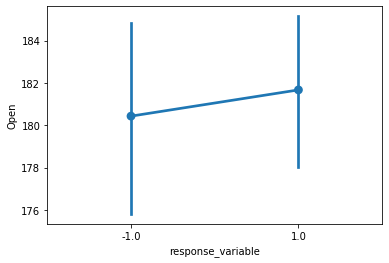

In [74]:
sns.pointplot(x='response_variable',y='Open',data=final_df_full)

There is a positive slope, which indicates that there is correlation between Opening Price and the target value/ a positive relationship between opening price and target value.

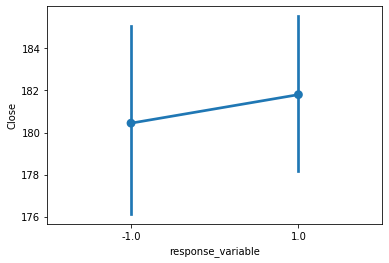

In [76]:
sns.pointplot(x='response_variable',y='Close',data=final_df_full)

There is a positive slope, which indicates that there is correlation between Closing Price and the target value/ a positive relationship between closing price and target value.

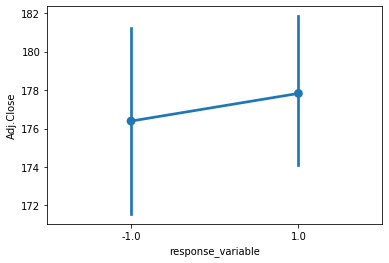

In [108]:
sns.pointplot(x='response_variable',y='Adj.Close',data=final_df_full)

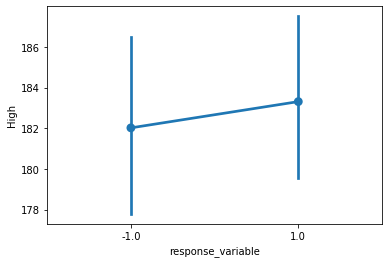

In [138]:
sns.pointplot(x='response_variable',y='High',data=final_df_full)

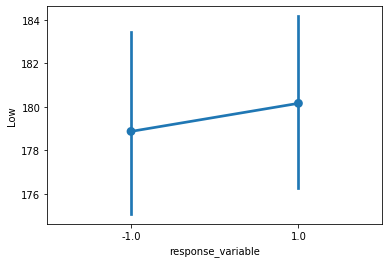

In [140]:
sns.pointplot(x='response_variable',y='Low',data=final_df_full)

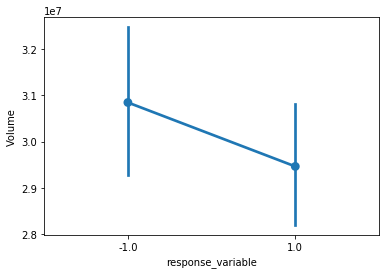

In [78]:
sns.pointplot(x='response_variable',y='Volume',data=final_df_full)

(10000000, 100000000)

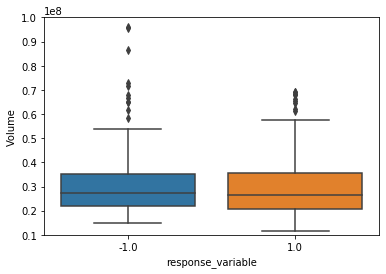

In [107]:
sns.boxplot(x='response_variable',y='Volume',data=final_df_full)
plt.ylim(10000000,100000000)

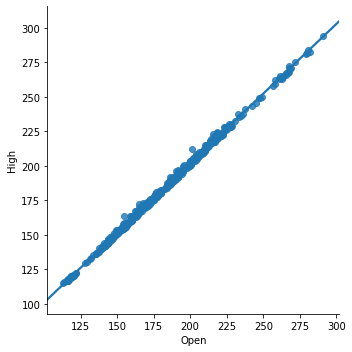

In [112]:
sns.lmplot(x='Open',y='High',data=final_df_full)

Strong correlation between Opening price and high, therefore unnecessary to include both variable

In [130]:
final_df_full.loc[:,'Open':'Volume'].corr()

,Open,High,Low,Close,Adj.Close,Volume
Open,1.000000,0.999235,0.998882,0.998100,0.997640,0.016574
High,0.999235,1.000000,0.998667,0.998931,0.998579,0.028357
Low,0.998882,0.998667,1.000000,0.999151,0.998526,-0.007105
Close,0.998100,0.998931,0.999151,1.000000,0.999392,0.004847
Adj.Close,0.997640,0.998579,0.998526,0.999392,1.000000,0.007145
Volume,0.016574,0.028357,-0.007105,0.004847,0.007145,1.000000


,Date,Open,High,Low,Close,Adj.Close,Volume,Revenue,Changes.in.working.capital,Dividend.paid,...,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,2016-12-12,113.290001,115.000000,112.489998,113.300003,107.975121,26374400,46852,4127,-3902,...,-0.552347,0.163983,0.324164,0.220682,0.069343,0.218765,0.099318,0.364117,-0.395187,-0.157688
1,2016-12-13,113.839996,115.919998,113.750000,115.190002,109.776306,43733800,46852,4127,-3902,...,-0.872536,0.273842,0.259738,0.481451,0.204496,0.165755,0.579278,0.645688,-0.720822,-0.270927
2,2016-12-14,115.040001,116.199997,114.980003,115.190002,109.776306,34031800,46852,4127,-3902,...,-1.054724,0.328718,0.359539,0.593207,0.199956,0.295405,0.609745,0.571464,-0.715015,-0.200304
3,2016-12-16,116.470001,116.500000,115.650002,115.970001,110.519630,44351100,46852,4127,-3902,...,-0.562094,0.231623,0.166944,0.400063,0.052655,0.125330,0.319319,0.434667,-0.400582,-0.156669
4,2016-12-19,115.800003,117.379997,115.750000,116.639999,111.158150,27779400,46852,4127,-3902,...,-0.720888,0.277393,0.474249,0.428098,0.098663,0.162281,0.487950,0.496552,-0.627744,-0.258895


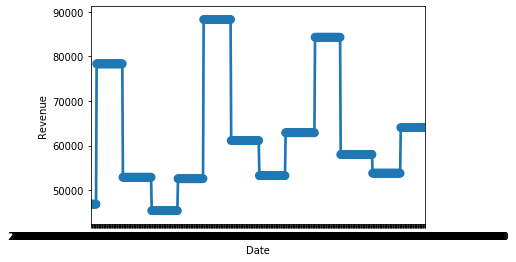

In [142]:
sns.pointplot(x='Date',y='Revenue',col='response_variable',data=final_df_full)

In [161]:
sentiments_df.head()

,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable
0,113.290001,112.489998,26374400,0.0,0.0000,1.0
1,113.839996,113.750000,43733800,0.0,0.0000,-1.0
2,115.040001,114.980003,34031800,-1.0,-0.3818,1.0
3,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0
4,115.800003,115.750000,27779400,0.0,0.0000,1.0


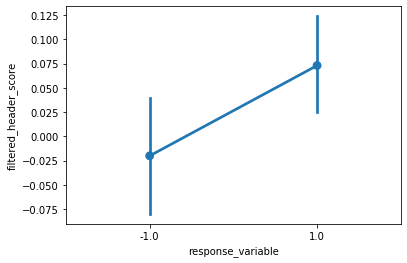

In [162]:
sns.pointplot(x='response_variable',y='filtered_header_score',data=sentiments_df)

# Building Classification Model

1. Support-Vector Machine
2. Random Forest 
3. K-Nearest Neighbor

In [38]:
sentiments_df.head()
import sklearn

In [39]:
sentiments_df.head()

,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable
0,113.290001,112.489998,26374400,0.0,0.0000,1.0
1,113.839996,113.750000,43733800,0.0,0.0000,-1.0
2,115.040001,114.980003,34031800,-1.0,-0.3818,1.0
3,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0
4,115.800003,115.750000,27779400,0.0,0.0000,1.0


In [40]:
print(sentiments_df[sentiments_df['filtered_header_sentiments']==0].shape[0])
print(sentiments_df[sentiments_df['filtered_header_sentiments']==1].shape[0])
print(sentiments_df[sentiments_df['filtered_header_sentiments']==-1].shape[0])

128
214
193


In [41]:
senti_embedding.head()

,Open,Low,Volume,filtered_header_sentiments,filtered_header_score,response_variable,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,113.290001,112.489998,26374400,0.0,0.0000,1.0,-0.142137,0.091775,-0.150318,-0.520471,0.529704,0.075626,-0.501385,-0.439765,-0.122840,-0.004761
1,113.839996,113.750000,43733800,0.0,0.0000,-1.0,-0.178653,0.248340,0.090407,-0.721978,0.735345,-0.306548,-0.837949,-0.753428,-0.250909,-0.045568
2,115.040001,114.980003,34031800,-1.0,-0.3818,1.0,-0.142346,0.210330,-0.011960,-0.719781,0.826492,-0.244534,-0.904540,-0.748386,-0.154801,0.198484
3,116.470001,115.650002,44351100,-1.0,-0.2960,-1.0,-0.053489,0.228733,0.177660,-0.454559,0.543408,-0.107909,-0.670617,-0.614683,-0.182140,-0.025391
4,115.800003,115.750000,27779400,0.0,0.0000,1.0,-0.136149,0.192712,0.006159,-0.611215,0.781135,0.054675,-0.745306,-0.455797,-0.134216,0.072733


In [42]:
lol=senti_embedding.iloc[:,[0,1,2,4,6,7,8,9,10,11,12,13,14,15]]

In [60]:
lol.head()

,Open,Low,Volume,filtered_header_score,coordinate_1,coordinate_2,coordinate_3,coordinate_4,coordinate_5,coordinate_6,coordinate_7,coordinate_8,coordinate_9,coordinate_10
0,113.290001,112.489998,26374400,0.0000,-0.509483,-0.049741,0.152693,-0.054295,-0.227845,0.212040,-0.112146,0.370702,-0.066835,-0.976316
1,113.839996,113.750000,43733800,0.0000,-0.550780,-0.326948,0.362956,-0.159433,-0.493889,0.104700,-0.143589,0.733934,-0.006070,-1.491136
2,115.040001,114.980003,34031800,-0.3818,-0.675908,-0.421710,0.370115,-0.109673,-0.474313,0.429052,-0.150567,0.783549,0.027242,-1.748820
3,116.470001,115.650002,44351100,-0.2960,-0.401450,-0.310321,0.278252,-0.079630,-0.383316,0.194918,-0.066800,0.508849,-0.066563,-1.041608
4,115.800003,115.750000,27779400,0.0000,-0.430939,-0.326467,0.175124,-0.263127,-0.253255,0.151143,-0.127728,0.493786,-0.057706,-1.256526


In [43]:
# convert regressors and response into list format 
Y=np.asarray(sentiments_df['response_variable'])
X=np.asarray(sentiments_df.iloc[:,[0,1,2,3]]) #filtered_header_sentiments
X2=np.asarray(sentiments_df.iloc[:,[0,1,2,4]]) #score
X3= np.asarray(senti_embedding.iloc[:,[0,1,2,3,6,7,8,9,10,11,12,13,14,15]]) #class+embeddings
X4=np.asarray(senti_embedding.iloc[:,[0,1,2,4,6,7,8,9,10,11,12,13,14,15]])  #score+embeddings

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, train_size=0.8)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, Y, train_size=0.8)
x_train4, x_test4, y_train4, y_test4 = train_test_split(X4, Y, train_size=0.8)
x_train.shape

(428, 4)

### Support-Vector Machine

In [82]:
x_train = sklearn.preprocessing.scale(x_train)
x_train2 = sklearn.preprocessing.scale(x_train2)
x_train3 = sklearn.preprocessing.scale(x_train3)
x_train4 = sklearn.preprocessing.scale(x_train4)

x_train.shape

(428, 4)

In [96]:
SVM=sklearn.svm.LinearSVC(penalty='l2',loss='squared_hinge',dual=False)

In [192]:

SVM.fit(x_train,y_train)
y_pred = SVM.predict(x_test)
print((accuracy_score(y_train,SVM.predict(x_train)),accuracy_score(y_test,y_pred),metrics.roc_auc_score(y_test,SVM.predict(x_test))))

#dual=True variance is larger
#dual=False results more stable

(0.5560747663551402, 0.411214953271028, 0.5)


In [193]:

SVM.fit(x_train2,y_train2)
y_pred2 = SVM.predict(x_test2)
print((accuracy_score(y_train2,SVM.predict(x_train2)),accuracy_score(y_test2,y_pred2),metrics.roc_auc_score(y_test2,SVM.predict(x_test2))))

(0.5794392523364486, 0.4672897196261682, 0.5)


In [194]:

SVM.fit(x_train3,y_train3)
y_pred3 = SVM.predict(x_test3)
print(accuracy_score(y_train3,SVM.predict(x_train3)),accuracy_score(y_test3,y_pred3),metrics.roc_auc_score(y_test3,SVM.predict(x_test3)))

0.6121495327102804 0.5514018691588785 0.5


In [195]:

SVM.fit(x_train4,y_train4)
y_pred4 = SVM.predict(x_test4)
print(accuracy_score(y_train4,SVM.predict(x_train4)),accuracy_score(y_test4,y_pred4),metrics.roc_auc_score(y_test4,SVM.predict(x_test4)))

0.602803738317757 0.5327102803738317 0.5


### Random Forest

In [75]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, train_size=0.8)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, Y, train_size=0.8)
x_train4, x_test4, y_train4, y_test4 = train_test_split(X4, Y, train_size=0.8)

In [175]:
model_RF=RandomForestClassifier(n_estimators=10,bootstrap=True)

In [188]:
model_RF.fit(x_train,y_train)

acc_train=metrics.accuracy_score(y_train,model_RF.predict(x_train))
acc_test= metrics.accuracy_score(y_test,model_RF.predict(x_test))
(acc_train,acc_test,metrics.roc_auc_score(y_test,model_RF.predict(x_test)))

(0.9649532710280374, 0.411214953271028, 0.5)

In [189]:
model_RF.fit(x_train2,y_train2)
acc_train=metrics.accuracy_score(y_train2,model_RF.predict(x_train2))
acc_test= metrics.accuracy_score(y_test2,model_RF.predict(x_test2))
(acc_train,acc_test,metrics.roc_auc_score(y_test2,model_RF.predict(x_test2)))

(0.985981308411215, 0.5233644859813084, 0.5170175438596492)

In [190]:
model_RF.fit(x_train3,y_train3)
acc_train=metrics.accuracy_score(y_train3,model_RF.predict(x_train3))
acc_test= metrics.accuracy_score(y_test3,model_RF.predict(x_test3))
(acc_train,acc_test,metrics.roc_auc_score(y_test3,model_RF.predict(x_test3)))

(0.9836448598130841, 0.5700934579439252, 0.5538488700564971)

In [191]:
model_RF.fit(x_train4,y_train4)
acc_train=metrics.accuracy_score(y_train4,model_RF.predict(x_train4))
acc_test= metrics.accuracy_score(y_test4,model_RF.predict(x_test4))
(acc_train,acc_test,metrics.roc_auc_score(y_test4,model_RF.predict(x_test4)))

(0.9836448598130841, 0.5514018691588785, 0.5298245614035088)

In [79]:
final_df_full.columns[0]

'Date'

In [114]:
importances2 = model_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_RF.estimators_],
             axis=0)
indices = np.argsort(importances2)[::-1]

for f in range(10):
    print("%d. feature %s (%f)" % (f + 1, final_df_full.columns[indices[f]+1], importances2[indices[f]]))

1. feature Volume (0.188424)
2. feature Open (0.150504)
3. feature Low (0.146192)
4. feature Close (0.140951)
5. feature High (0.139750)
6. feature Adj.Close (0.136741)
7. feature Dividend.paid (0.028076)
8. feature Net.changes.in.cash (0.027731)
9. feature Changes.in.working.capital (0.021951)
10. feature Revenue (0.019679)


In [38]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

In [39]:
indices = np.argsort(importances)[::-1]

In [40]:
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 1784 (0.037131)
2. feature 1782 (0.037062)
3. feature 1781 (0.031227)
4. feature 0 (0.022935)
5. feature 4 (0.021791)
6. feature 2 (0.021642)
7. feature 1788 (0.019548)
8. feature 3 (0.019429)
9. feature 1787 (0.019072)
10. feature 1786 (0.017433)


In [41]:
final_df_full.columns[10]

'filtered_header_sentiments'

# Logistic Regression

In [124]:
from sklearn.linear_model import LogisticRegression
LR=LogisticRegression(penalty='l1',solver='saga',max_iter=1000)
#LR= sklearn.linear_model.LogisticRegressionCV(cv=10,solver='saga',penalty='l2')

In [125]:
LR.fit(x_train,y_train)
predicted=LR.predict(x_test)
print(metrics.accuracy_score(y_train,LR.predict(x_train),metrics.accuracy_score(y_test,LR.predict(x_test))))
f1_score=metrics.roc_auc_score(y_test,predicted)
print(f1_score)

0.5700934579439252
0.5


In [126]:
LR.fit(x_train2,y_train2)
predicted=LR.predict(x_test2)
print(metrics.accuracy_score(y_train2,LR.predict(x_train2),metrics.accuracy_score(y_test2,LR.predict(x_test2))))
f1_score=metrics.roc_auc_score(y_test2,predicted)
print(f1_score)

0.5677570093457944
0.5


In [127]:
LR.fit(x_train3,y_train3)
predicted=LR.predict(x_test3)
print(metrics.accuracy_score(y_train3,LR.predict(x_train3),metrics.accuracy_score(y_test3,LR.predict(x_test3))))
f1_score=metrics.roc_auc_score(y_test3,predicted)
print(f1_score)

0.6004672897196262
0.5


In [128]:
LR.fit(x_train4,y_train4)
predicted=LR.predict(x_test4)
print(metrics.accuracy_score(y_train4,LR.predict(x_train4),metrics.accuracy_score(y_test4,LR.predict(x_test4))))
f1_score=metrics.roc_auc_score(y_test4,predicted)
print(f1_score)

0.5911214953271028
0.5


### K Nearest Neighbor

In [129]:
x_train = sklearn.preprocessing.scale(x_train)
x_train2 = sklearn.preprocessing.scale(x_train2)
x_train3 = sklearn.preprocessing.scale(x_train3)
x_train4 = sklearn.preprocessing.scale(x_train4)



for i in range(1,20):    
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train, y_train)
    print([i,"neighbours",metrics.accuracy_score(y_train,KNN.predict(x_train)),metrics.accuracy_score(y_test,KNN.predict(x_test)),metrics.roc_auc_score(y_test,KNN.predict(x_test))])


[1, 'neighbours', 1.0, 0.411214953271028, 0.5]
[2, 'neighbours', 0.7336448598130841, 0.411214953271028, 0.5]
[3, 'neighbours', 0.7616822429906542, 0.411214953271028, 0.5]
[4, 'neighbours', 0.6939252336448598, 0.411214953271028, 0.5]
[5, 'neighbours', 0.705607476635514, 0.411214953271028, 0.5]
[6, 'neighbours', 0.6752336448598131, 0.411214953271028, 0.5]
[7, 'neighbours', 0.6939252336448598, 0.411214953271028, 0.5]
[8, 'neighbours', 0.6612149532710281, 0.411214953271028, 0.5]
[9, 'neighbours', 0.6448598130841121, 0.411214953271028, 0.5]
[10, 'neighbours', 0.6728971962616822, 0.411214953271028, 0.5]
[11, 'neighbours', 0.6588785046728972, 0.5887850467289719, 0.5]
[12, 'neighbours', 0.6658878504672897, 0.5887850467289719, 0.5]
[13, 'neighbours', 0.6518691588785047, 0.5887850467289719, 0.5]
[14, 'neighbours', 0.6261682242990654, 0.411214953271028, 0.5]
[15, 'neighbours', 0.6401869158878505, 0.5887850467289719, 0.5]
[16, 'neighbours', 0.6261682242990654, 0.5887850467289719, 0.5]
[17, 'neighb

In [131]:

for i in range(1,50):    
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train2, y_train2)
    print([i,"neighbours",
           metrics.accuracy_score(y_train2,KNN.predict(x_train2)),
           metrics.accuracy_score(y_test2,KNN.predict(x_test2)),metrics.roc_auc_score(y_test2,KNN.predict(x_test2))])



[1, 'neighbours', 1.0, 0.4672897196261682, 0.5]
[2, 'neighbours', 0.7616822429906542, 0.4672897196261682, 0.5]
[3, 'neighbours', 0.7593457943925234, 0.4672897196261682, 0.5]
[4, 'neighbours', 0.719626168224299, 0.4672897196261682, 0.5]
[5, 'neighbours', 0.6869158878504673, 0.4672897196261682, 0.5]
[6, 'neighbours', 0.6705607476635514, 0.4672897196261682, 0.5]
[7, 'neighbours', 0.6682242990654206, 0.4672897196261682, 0.5]
[8, 'neighbours', 0.6448598130841121, 0.4672897196261682, 0.5]
[9, 'neighbours', 0.616822429906542, 0.4672897196261682, 0.5]
[10, 'neighbours', 0.6191588785046729, 0.4672897196261682, 0.5]
[11, 'neighbours', 0.616822429906542, 0.5327102803738317, 0.5]
[12, 'neighbours', 0.6121495327102804, 0.4672897196261682, 0.5]
[13, 'neighbours', 0.6214953271028038, 0.5327102803738317, 0.5]
[14, 'neighbours', 0.616822429906542, 0.5327102803738317, 0.5]
[15, 'neighbours', 0.6191588785046729, 0.5327102803738317, 0.5]
[16, 'neighbours', 0.6238317757009346, 0.5327102803738317, 0.5]
[17,

In [132]:

for i in range(1,50):    
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train3, y_train3)
    print([i,"neighbours",metrics.accuracy_score(y_train3,KNN.predict(x_train3)),metrics.accuracy_score(y_test3,KNN.predict(x_test3)),metrics.roc_auc_score(y_test3,KNN.predict(x_test3))])



[1, 'neighbours', 1.0, 0.5514018691588785, 0.5]
[2, 'neighbours', 0.7593457943925234, 0.5514018691588785, 0.5]
[3, 'neighbours', 0.7453271028037384, 0.5514018691588785, 0.5]
[4, 'neighbours', 0.6939252336448598, 0.5514018691588785, 0.5]
[5, 'neighbours', 0.6822429906542056, 0.5514018691588785, 0.5]
[6, 'neighbours', 0.6588785046728972, 0.5514018691588785, 0.5]
[7, 'neighbours', 0.6495327102803738, 0.5514018691588785, 0.5]
[8, 'neighbours', 0.6378504672897196, 0.5514018691588785, 0.5]
[9, 'neighbours', 0.6588785046728972, 0.5514018691588785, 0.5]
[10, 'neighbours', 0.6191588785046729, 0.5514018691588785, 0.5]
[11, 'neighbours', 0.6191588785046729, 0.5514018691588785, 0.5]
[12, 'neighbours', 0.6191588785046729, 0.5514018691588785, 0.5]
[13, 'neighbours', 0.6098130841121495, 0.5514018691588785, 0.5]
[14, 'neighbours', 0.6121495327102804, 0.5514018691588785, 0.5]
[15, 'neighbours', 0.6144859813084113, 0.5514018691588785, 0.5]
[16, 'neighbours', 0.6074766355140186, 0.5514018691588785, 0.5]


In [133]:
for i in range(1,50):    
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(x_train4, y_train4)
    print([i,"neighbours",metrics.accuracy_score(y_train4,KNN.predict(x_train4)),metrics.accuracy_score(y_test4,KNN.predict(x_test4)),metrics.roc_auc_score(y_test4,KNN.predict(x_test4))])




[1, 'neighbours', 1.0, 0.5327102803738317, 0.5]
[2, 'neighbours', 0.7757009345794392, 0.5327102803738317, 0.5]
[3, 'neighbours', 0.7733644859813084, 0.5327102803738317, 0.5]
[4, 'neighbours', 0.6985981308411215, 0.5327102803738317, 0.5]
[5, 'neighbours', 0.7336448598130841, 0.5327102803738317, 0.5]
[6, 'neighbours', 0.6962616822429907, 0.5327102803738317, 0.5]
[7, 'neighbours', 0.6635514018691588, 0.5327102803738317, 0.5]
[8, 'neighbours', 0.6518691588785047, 0.5327102803738317, 0.5]
[9, 'neighbours', 0.6495327102803738, 0.4672897196261682, 0.5]
[10, 'neighbours', 0.6285046728971962, 0.4672897196261682, 0.5]
[11, 'neighbours', 0.6238317757009346, 0.4672897196261682, 0.5]
[12, 'neighbours', 0.6004672897196262, 0.4672897196261682, 0.5]
[13, 'neighbours', 0.6051401869158879, 0.4672897196261682, 0.5]
[14, 'neighbours', 0.6051401869158879, 0.4672897196261682, 0.5]
[15, 'neighbours', 0.6191588785046729, 0.4672897196261682, 0.5]
[16, 'neighbours', 0.6285046728971962, 0.4672897196261682, 0.5]


AdaBoost

In [200]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y, train_size=0.8)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, Y, train_size=0.8)
x_train4, x_test4, y_train4, y_test4 = train_test_split(X4, Y, train_size=0.8)

In [196]:
from sklearn.ensemble import AdaBoostClassifier


In [294]:
model_AB=  AdaBoostClassifier(n_estimators=100,learning_rate=0.1)

In [299]:

model_AB.fit(x_train,y_train)
predicted=model_AB.predict(x_test)
print((metrics.accuracy_score(y_train,model_AB.predict(x_train)),metrics.accuracy_score(y_test,predicted),metrics.roc_auc_score(y_test,predicted)))

(0.6425233644859814, 0.48598130841121495, 0.449468085106383)


In [300]:
model_AB.fit(x_train2,y_train2)
predicted=model_AB.predict(x_test2)
print((metrics.accuracy_score(y_train2,model_AB.predict(x_train2)),metrics.accuracy_score(y_test2,predicted),metrics.roc_auc_score(y_test2,predicted)))

(0.6425233644859814, 0.5514018691588785, 0.5124113475177305)


In [303]:
model_AB.fit(x_train3,y_train3)
predicted=model_AB.predict(x_test3)
print((metrics.accuracy_score(y_train3,model_AB.predict(x_train3)),metrics.accuracy_score(y_test3,predicted),metrics.roc_auc_score(y_test3,predicted)))

(0.7429906542056075, 0.616822429906542, 0.5992063492063492)


In [302]:
model_AB.fit(x_train4,y_train4)
predicted=model_AB.predict(x_test4)
print((metrics.accuracy_score(y_train4,model_AB.predict(x_train4)),metrics.accuracy_score(y_test4,predicted),metrics.roc_auc_score(y_test4,predicted)))

(0.7172897196261683, 0.5327102803738317, 0.504632929436921)


Neural Network

In [32]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import variable

In [33]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN.self).__init__()
        
        self.hidden_size=hidden_size
        self.outputlayer=nn.Linear(input_size+hidden_size,output_size)
        self.hiddenlayer=nn.Linear(input_size_hidden_size,hidden_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        combinetorch.cat((input,hidden),1)
        hidden=self.hiddenlayer(combined)
        output=self.softmax(self.outputlayer(combined))
    
    def inithidden(self):
        return torch.zeros(1,self.hidden_size)
                            
        

# The End 